# Seasonality Extractor
Imports data from G-Sheets, flags outliers & holidays + calculates seasonality

In [1]:
import Bens_forecasting_utils as fc
import pandas as pd
%matplotlib ipympl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
plt.rcParams['figure.figsize'] = [10, 5] # make default plot size bigger
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

### Set parameters here:

In [2]:
parameters = dict(
    
    input_sheet_id             = '1248eYeDNGzEDxiBU_QskVoR5ukvMZm5aeHZfHR8T4Qo',
    input_sheet_range          = 'raw!A1:C',
    holidays_sheet_id          = '18TZ4zdkox5Es4PWwJijoYk3FfDusjfi6itDv56oiIhU',
    holidays_sheet_range       = 'holidays!A1:F',
    stddev_threshold           = 3,
    outlier_rolling_window     = 13,
    monthly_seasonality_window = 14,
    wrap_monthly_seasonality   = False,
    weekly_seasonality_window  = 26,
    enable_verbose_logging     = False    # Requires kernel restart to take effect
)

**Note:** first time run will prompt authorisation with Google SSO for the G-Sheets API. After that a `token.json` file will be stored locally containing API credentials.

Credentials will remain valid unless they are not used for 6 months (or if the API scope is changed in `Bens_forecasting_utils.py`). In this case you may need to manually delete `token.json` to trigger the Google SSO authorisation flow upon the next execution.

---

### Import raw data and do pre-processing:
Flag Outliers, Holidays & extract intra-month & intra-week seasonality.

In [3]:
%%time

df_dict = fc.main(**parameters)

df_raw_vol = df_dict[0]
df_intra_month_seasonality = df_dict[1]
df_intra_week_seasonality = df_dict[2]

raw seasonality null check: 0
CPU times: user 395 ms, sys: 50.2 ms, total: 445 ms
Wall time: 2.29 s


interactive(children=(Dropdown(description='business_line', options=('ops-cmp-ESP-Authority-Payments Operation…

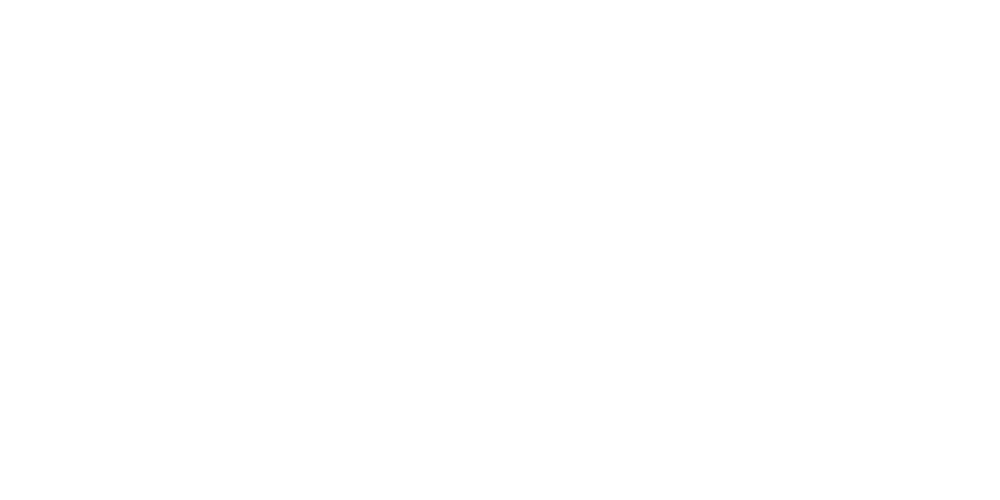

In [4]:
def plot_vol(business_line):
    graphData = df_raw_vol.loc[(df_raw_vol['business_line_alias'] == business_line) & (df_raw_vol['date'] > '2020-01-01') & (df_raw_vol['date'] < '2024-02-18')]
    plt.figure(1)
    plotMax = max(graphData['value'])
    plotMin = min(graphData['value'])
    plt.clf()
    plt.plot(graphData['date'], graphData['value'])
    plt.plot(graphData['date'], graphData['rolling_mean'], color='red', linewidth=0.5, linestyle='--')
    plt.plot(graphData['date'], graphData['low_outlier_threshold'], color='#dfeffa', linewidth=0.3, linestyle='--')
    plt.plot(graphData['date'], graphData['high_outlier_threshold'], color='#dfeffa', linewidth=0.3, linestyle='--')
    plt.fill_between(graphData['date'], graphData['low_outlier_threshold'], graphData['high_outlier_threshold'], color='#f5fbff')
    plt.fill_between(graphData['date'], plotMin, plotMax, where=graphData['is_stdv_stats_outlier'] == True, color='#f8e7e7', linewidth=3)
    plt.fill_between(graphData['date'], plotMin, plotMax, where=graphData['is_holiday'] == True,color='#d9ead3', linewidth=3)
    plt.title(graphData['business_line_alias'].iat[0])

dropdown = widgets.interact(
    plot_vol, 
    business_line=df_raw_vol['business_line_alias'].unique()
)

# Key:
# blue line = value           red dotted line = local avg           blue area = outlier upper/lower bounds
# red bar  = outlier          green bar = national holiday

Note: running a chart cell twice will cause the chart to dissappear. (This is [intended behaviour](https://github.com/matplotlib/ipympl/issues/60) for some reason 🤷‍♂️).

To fix: re-run the first cell in the notebook (containing the `%matplotlib ipympl` magic command), then re-run the chart cell again.

interactive(children=(Dropdown(description='business_line', options=('ops-cmp-DEU-Authority-AFC & AML', 'ops-c…

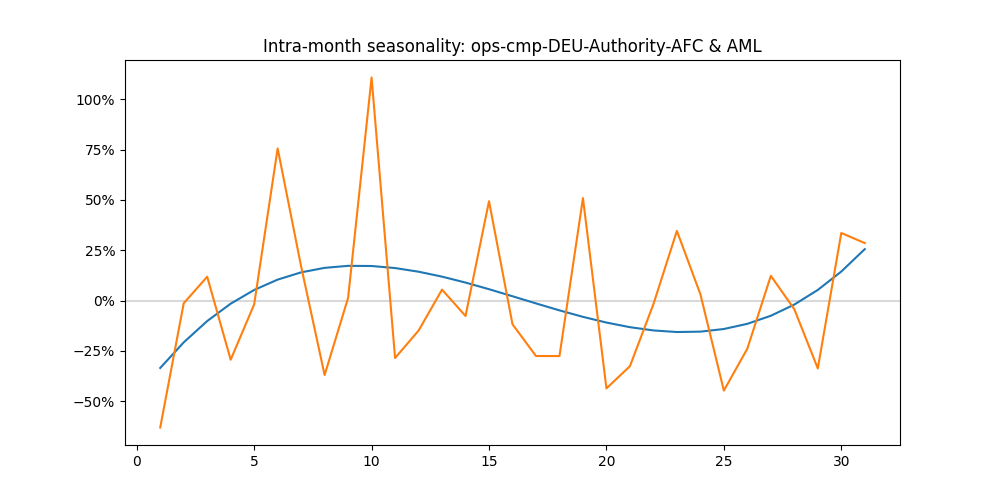

In [5]:
def plot_intra_month_seasonality(business_line):
    graphData = df_intra_month_seasonality.loc[(df_intra_month_seasonality['business_line_alias'] == business_line)]
    plt.figure(2)
    plotMax = max(graphData['avg_vol'])
    plt.clf()
    plt.axhline(0, color="black", alpha=0.15)
    plt.plot(graphData['dom'], graphData['intra_month_seasonality'])
    plt.plot(graphData['dom'], graphData['avg_vol'])
    plt.title('Intra-month seasonality: ' + graphData['business_line_alias'].iat[0])
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

dropdown = widgets.interact(
    plot_intra_month_seasonality, 
    business_line=df_intra_month_seasonality['business_line_alias'].unique()
)

# Key:
# blue line = smoothing spline seasonality          orange bar  = raw seasonality

interactive(children=(Dropdown(description='business_line', options=('ops-cmp-DEU-Authority-AFC & AML', 'ops-c…

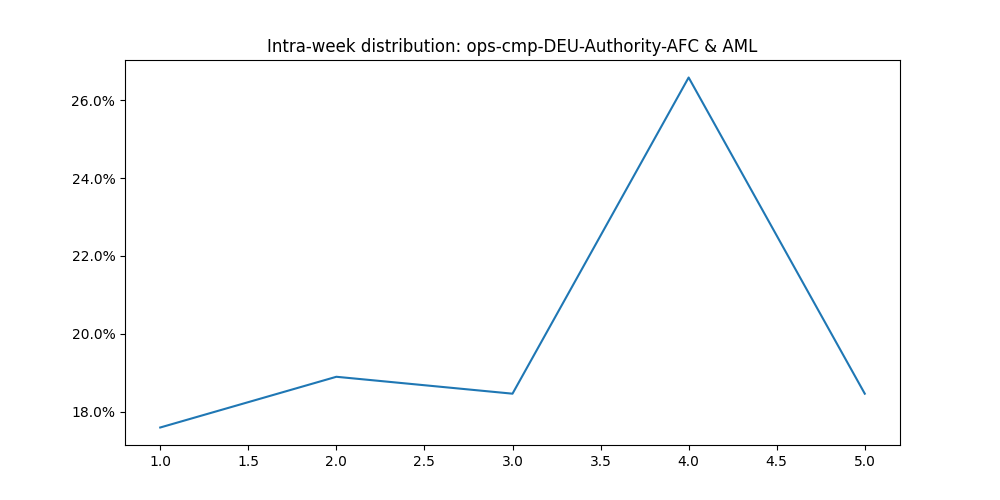

In [6]:
def plot_intra_week_seasonality(business_line):
    graphData = df_intra_week_seasonality.loc[(df_intra_week_seasonality['business_line_alias'] == business_line)]
    plt.figure(3)
    plotMax = max(graphData['avg_vol'])
    plt.clf()
    plt.plot(graphData['dow'], graphData['intra_week_distro'])
    #plt.plot(graphData['dow'], graphData['avg_vol'])
    plt.title('Intra-week distribution: ' + graphData['business_line_alias'].iat[0])
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

dropdown = widgets.interact(
    plot_intra_week_seasonality, 
    business_line=df_intra_week_seasonality['business_line_alias'].unique()
)

# Key:
# blue line = intra-week split

In [7]:


intra_month_gsheet_export_params = dict(
    
    df                 = df_intra_month_seasonality,
    gsheet_id          = parameters['input_sheet_id'], #export to input sheet
    gsheet_tab_name    = 'intra_month_seasonality',
    include_df_headers = True,
    tab_colour         = (0.0, 0.0, 0.0) #RGB tab colour
)

intra_week_gsheet_export_params = dict(
    
    df                 = df_intra_week_seasonality,
    gsheet_id          = parameters['input_sheet_id'], #export to input sheet
    gsheet_tab_name    = 'intra_week_seasonality',
    include_df_headers = True,
    tab_colour         = (0.0, 0.0, 0.0) #RGB tab colour
)

# The date column must be converted to a string because timestamp type is not JSON serialisable & Gsheets cannot parse it.
# Once this is done the volume overview chart above will throw an error because the date column is now text.
df_raw_vol['date'] = df_raw_vol['date'].dt.strftime('%Y-%m-%d %H:%M:%S')

clean_vol_gsheet_export_params = dict(
    
    df                 = df_raw_vol,
    gsheet_id          = parameters['input_sheet_id'], #export to input sheet
    gsheet_tab_name    = 'clean_raw_vol',
    include_df_headers = True,
    tab_colour         = (0.0, 0.0, 0.0) #RGB tab colour
)

fc.export_df_to_google_sheet(**intra_month_gsheet_export_params)

fc.export_df_to_google_sheet(**intra_week_gsheet_export_params)

fc.export_df_to_google_sheet(**clean_vol_gsheet_export_params)
